## Imports

In [1]:
# PYTHON
import os
import random
import librosa
from scipy.io import wavfile
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from collections import defaultdict

# JUPYTER
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#PYTORCH
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable as V
from torch import optim
from torch.utils.data.sampler import *

## Dataset Classes

### 1.1 Log Mel Spectogram Class

Let's show an example of a Dataset and how we do the transformations from wav file into images of log mel spectogram. We need to scale data so that every image same size.

In [11]:
class logSpecData(Dataset):
    def __init__(self, file_path, classes, sample_ratio=1.0):
        self.file_path = file_path
        self.classes = classes
        img_paths = []
        for c in classes:
            for img_path in os.listdir(file_path + c):
                img_paths.append(file_path + c + '/' +  img_path)
        #shuffle with sorted
        #subsample for easier experimentation 
        random.shuffle(img_paths)
        self.img_paths = img_paths[:int(len(img_paths)*sample_ratio)]
        
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = img_path.split('/')[4]
        #read wav file
        sample_rate, samples = wavfile.read(img_path)
        #get mel spectogram and log mel spectogram
        S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
        log_S = librosa.power_to_db(S, ref=np.max)
        #get label index from classes
        label_idx = np.where(np.array(classes) == label)[0][0]
        img = log_S.T
        #resize images that are not in right size
        if img.shape != (32, 128):
            img = resize(log_S.T, (32, 128))
        #add dimension for 1 channel image
        img = img[None, :]
        return img, label_idx 
        
    def __len__(self): 
        return len(self.img_paths)

In [12]:
# here is a list of the classes to be predicted
classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']

In [13]:
train_path = '../data/train/train/'
val_path = '../data/train/val/'

In [14]:
train_ds = logSpecData(train_path, classes)
val_ds = logSpecData(val_path, classes)

In [15]:
len(train_ds.img_paths), len(val_ds.img_paths)

(71123, 8118)

In [16]:
train_data = iter(DataLoader(train_ds ,shuffle=True))

torch.Size([1, 1, 32, 128])


(
  9
 [torch.LongTensor of size 1], <matplotlib.image.AxesImage at 0x7f5628232d30>)

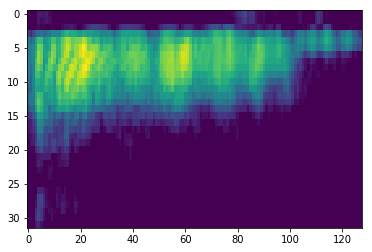

In [17]:
log_s, label = next(train_data)
print (log_s.size())
label, plt.imshow(log_s.numpy()[0][0], aspect='auto')

## Creating Dataloaders

- We will define a weighted random sampler to balance class samples
- This sampler expects weigths for each data point in the dataset
- For this example we will balance out unknown and silence samples

In [18]:
def get_sampler_weights(dataset):
    labels = [i.split('/')[4] for i in dataset.img_paths]
    count_dict = Counter(labels)
    total_count = sum(count_dict.values())
    weight_dict = {k:total_count / count_dict[k] for k in count_dict}
    weights = np.vectorize(weight_dict.get)(np.array(labels))
    return weights, weight_dict

## NN Models

### 1.1 CNN_TRAD_POOL2_NET

This model is coming from tensorflow automatic speech recognition tutorial. It's a fairly simple model but it will be a good start.

In [275]:
class cnn_trad_pool2_net(nn.Module):
    def __init__(self, in_shape=(1, 32, 128), num_classes=12):
        super(cnn_trad_pool2_net, self).__init__()
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(1,  64, kernel_size=(16, 8), stride=(1, 1))
        self.bn_conv1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(8, 4), stride=(1, 1))
        self.bn_conv2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(3648, num_classes)
    
    def forward(self, x):
        # maxpool + relu is faster than relu + maxpool equivalent ops
        # https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216/4
        x = self.bn_conv1(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=(2,2), stride=(2,2))
        x = F.relu(x)
       
        x = self.bn_conv2(self.conv2(x))
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc(x)
        return x

In [276]:
net = cnn_trad_pool2_net()

In [277]:
logits = net(V(log_s.float()))

In [278]:
logits, label.view(-1)

(Variable containing:
 
 Columns 0 to 9 
  0.0471  0.0165 -0.3035  0.1066  0.0496  0.3881 -0.2434 -0.4489  0.0133  0.1738
 
 Columns 10 to 11 
  0.1714  0.2849
 [torch.FloatTensor of size 1x12], 
  11
 [torch.LongTensor of size 1])

In [279]:
F.cross_entropy(logits, V(label.view(-1)))

Variable containing:
 2.2474
[torch.FloatTensor of size 1]

## Training Loop

A very good reference to use while training your neural network: https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

What to learn:

- sampler to get equal size class samples (**done**)
- Data Augmentation on audio data from scratch (do it after first model without it)
- saving models and logging (**done**)
- setting learning rate schedular
- use parallel gpus (**done**) http://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html#sphx-glr-beginner-blitz-data-parallel-tutorial-py. Doesn't work as expected.

Side notes: 
- learn about visdom

In [280]:
train_path, val_path

('../data/train/train/', '../data/train/val/')

In [281]:
# here is a list of the classes to be predicted
classes = ['yes', 'no']#, 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']

In [282]:
train_ds = logSpecData(train_path, classes, 0.5)
val_ds = logSpecData(val_path, classes, 0.5)

In [283]:
train_ds.__len__(), val_ds.__len__()

(2110, 265)

In [284]:
weights, weight_dict = get_sampler_weights(train_ds)
sampler = WeightedRandomSampler(weights, len(weights))
sampler_val = SequentialSampler(val_ds)
train_dl = DataLoader(train_ds, 128, sampler=sampler, drop_last=True, num_workers=8)
valid_dl = DataLoader(val_ds, 128, num_workers=8, sampler=sampler_val)

In [285]:
def evaluate(net, valid_dl):
    val_true = []
    val_pred = []
    for i, data in enumerate(valid_dl, 0):
        #get the inputs
        inputs, labels = data

        #wrap them in Variable
        inputs, labels = V(inputs.float()), V(labels)
        outputs = net(inputs)

        #get cross entropy loss and accuracy
        val_true.append(labels.data)
        val_pred.append(outputs.data)

    #define validation variables
    val_pred_concat = V(torch.cat(val_pred))
    val_true_concat = V(torch.cat(val_true))
    #validation cross entropy loss
    val_loss = criterion(val_pred_concat, val_true_concat).data[0]
    #validation accuracy
    _, class_pred = torch.max(val_pred_concat, 1)
    val_acc = sum((class_pred == val_true_concat).data) / len(class_pred)
    #confusion matrix
    cmat = confusion_matrix(val_true_concat.data.numpy(), class_pred.data.numpy())
    return val_loss, val_acc, cmat

In [286]:
def train(net, train_dl, valid_dl, criterion, optimizer, n):
    training_loss = []
    alpha = 0.98
    running_loss = 0.0
    batch_num = 0

    for epoch in range(n):  # loop over the dataset multiple times
        net.train() #back to training
        for i, data in enumerate(train_dl, 0):
            batch_num += 1
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = V(inputs.float()), V(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # compute debias running training loss
            training_loss.append(loss.data[0])
            running_loss = running_loss * alpha + loss.data[0] * (1 - alpha) 
            debias_loss = running_loss / (1 - alpha**batch_num)

        net.eval() #for dropout
        val_loss, val_acc, cmat = evaluate(net, valid_dl)
        #print epoch evaluation
        print(f'epoch {epoch}')
        print(f'[{debias_loss} ,{val_loss}, {val_acc}]\n')
        
        
        #save model at every 1000th step 
        if batch_num % 1000 == 0:
            torch.save(net.state_dict(), f'../models/trad_pool2d_{batch_num}')
            torch.save({'optimizer': optimizer.state_dict(),
                  'iter':batch_num, 
                  'epoch':epoch}, f'../models/trad_pool2d_optim_{batch_num}')

    #print final cmat
    print(cmat)
    return training_loss

In [377]:
#define network
#distribute module to gpu to work on parallel
net = cnn_trad_pool2_net()
if torch.cuda.is_available():
    n_devices = torch.cuda.device_count()
    print(f'Running model on {n_devices} GPUs')
    net = nn.DataParallel(net)
# define optimizer and criterion
criterion = F.cross_entropy
#optimizer = optim.SGD(net.parameters(),lr=0.005, momentum=0.9, weight_decay=0.0001)
optimizer = optim.Adam(net.parameters())

In [ ]:
training_loss = train(net, train_dl, valid_dl, criterion, optimizer, 10)

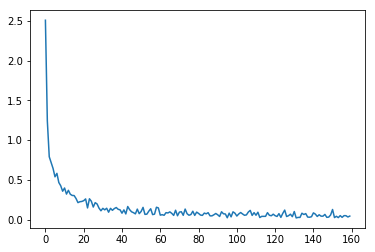

In [292]:
plt.plot(training_loss)

### Simple Ensembler by averaging parameter weigths

Will take n as number of ensemble models to train and then average their parameters to create a new model. Later we will evaluate by that new model.

In [387]:
new_state_dict = defaultdict(int)
n = 10 # no of models in ens
for i in range(n):
    net = cnn_trad_pool2_net()
    optimizer = optim.Adam(net.parameters())
    criterion = F.cross_entropy
    training_loss = train(net, train_dl, valid_dl, criterion, optimizer, 3)
    
    
    state_dict = net.state_dict()
    for k in state_dict:
        new_state_dict[k] += state_dict[k]

for k in new_state_dict:
    new_state_dict[k] = new_state_dict[k]/n

ens = cnn_trad_pool2_net()
ens.load_state_dict(new_state_dict)

epoch 0
[0.5516645131762007 ,0.4264965057373047, 0.7886792452830189]

epoch 1
[0.3355259768330036 ,0.18784357607364655, 0.9471698113207547]

epoch 2
[0.2467837575015801 ,0.24104395508766174, 0.9056603773584906]

[[112  24]
 [  1 128]]
epoch 0
[0.5471998469476788 ,0.21135440468788147, 0.9471698113207547]

epoch 1
[0.3225887188502619 ,0.45512375235557556, 0.7811320754716982]

epoch 2
[0.23291121836213027 ,0.16208305954933167, 0.9471698113207547]

[[134   2]
 [ 12 117]]
epoch 0
[0.5496209352649164 ,0.3165607154369354, 0.8981132075471698]

epoch 1
[0.33728072488481753 ,0.11709485203027725, 0.9622641509433962]

epoch 2
[0.23795432305005207 ,0.10839048027992249, 0.969811320754717]

[[129   7]
 [  1 128]]
epoch 0
[0.6015075511106445 ,0.23361769318580627, 0.9207547169811321]

epoch 1
[0.34947736314521544 ,0.21369147300720215, 0.9320754716981132]

epoch 2
[0.24728797747768017 ,0.2461717128753662, 0.9018867924528302]

[[119  17]
 [  9 120]]
epoch 0
[0.5845471274709265 ,0.3685843050479889, 0.8188

In [392]:
evaluate(ens.eval(), valid_dl)

(1.4701588153839111, 0.5132075471698113, array([[136,   0],
        [129,   0]]))

### Notes on Training

- Why does validation fluctuates?

**Possible Problem - Reaction**

**1)** class imbalance + unknown samples : Even with two classes eg. yes and no it fluctuates (-)

**2)** not enough data : Even when 1000 samples per class for yes and no (-). Though after adding batchnorm few data seems to cause fluctuation alone by itself.

**3)** Lacking normalization : Added another bn layer after conv2 (accuracy increased seems more stable less fluctuations) (+)

**4)** Early stopping: seems to also help since overfititing might later cause fluctuations (+)




## Fast.ai tricks